[View in Colaboratory](https://colab.research.google.com/github/modeverv/JupyterNotebook/blob/master/20180926.ipynb)

In [1]:
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80 chainer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 7s (3,673 kB/s)
Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
Unpacking libcusparse8.0:amd64 (8.0.61-1) ...
Selecting previously unselected package libnvrtc8.0:amd64.
Prepar

In [4]:
import cupy as cp
x = cp.arange(6).reshape(2, 3).astype('f')
x

array([[0., 1., 2.],
       [3., 4., 5.]], dtype=float32)

In [0]:
1 + 1 

2

In [5]:
# import numpy as np
import numpy as np

text = 'You say goodbye and I say hello.'

text = text.lower()
text = text.replace('.', ' .')
words = text.split(' ')
print(words)

word_to_id = {}
id_to_word = {}
for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

print(word_to_id)
print(id_to_word)

import numpy as np

corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
print(corpus)


['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
[0 1 2 3 4 1 5 6]


In [0]:
import numpy as np

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

In [7]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(word_to_id)

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [0]:
def cos_similarity(x, y,eps=1e-8):
    nx=x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny=y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


In [0]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix



In [10]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
c0 = C[word_to_id['you']] #「you」の単語ベクトル
c1 = C[word_to_id['i']] #「i」の単語ベクトル
print(cos_similarity(c0, c1))


0.7071067691154799


In [0]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print("%s is not found" % query)
        return
    
    print("\n[query] " + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print("%s: %s" % (id_to_word[i], similarity[i]))
        count += 1
        if count >= top:
            return
    



In [12]:


most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
goodbye: 0.7071067691154799
i: 0.7071067691154799
hello: 0.7071067691154799
say: 0.0
and: 0.0


In [0]:
def ppmi(C, verbose=False, eps=1e-8):
    M=np.zeros_like(C, dtype=np.float32)
    N=np.sum(C)
    S=np.sum(C, axis=0)
    total=C.shape[0] * C.shape[1]
    cnt=0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            if verbose:
                cnt += 1
                if cnt % (total // 100) == 0:
                    print("%.1f%% done" % (100 * cnt / total))
    
    return M

In [14]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)
np.set_printoptions(precision=3) # 有効桁3桁で表示
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


# Google Driveをマウントする
# Google Driveにあるdeep-learning-from-scratch-2のライブラリを読み込む例


In [7]:
from google.colab import drive
import sys
drive.mount('/content/drive')
libr =  '/content/drive/My Drive/Colab Notebooks/deep-learning-from-scratch-2'
sys.path.append(libr)
print(sys.path)
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

Mounted at /content/drive
['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Colab Notebooks/deep-learning-from-scratch-2']


In [8]:
!ls "/content/drive/My Drive/Colab Notebooks/deep-learning-from-scratch-2"

ch01  ch03  ch05  ch07	common	 LICENSE.md
ch02  ch04  ch06  ch08	dataset  README.md


['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Colab Notebooks/deep-learning-from-scratch-2', '..', '/content/drive/My Drive/Colab Notebooks/deep-learning-from-scratch-2']


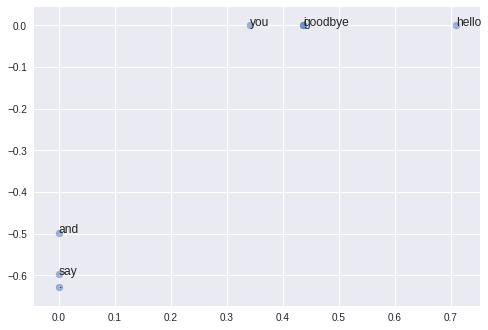

In [9]:
import sys
import os
libr =  '/content/drive/My Drive/Colab Notebooks/deep-learning-from-scratch-2'
sys.path.append(libr)
print(sys.path)
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0],U[word_id,1]))

plt.scatter(U[:,0], U[:,1],alpha=0.5)
plt.show()



ls: cannot access 'drive': No such file or directory


In [34]:
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb

window_size = 2
wordvec_size = 100
try:
    from sklearn.utils.extmath import randomized_svd
except ImportError:
    print("can't import")
    exit()
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (fast!)

    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    print("slow")
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


counting  co-occurrence ...
calculating PPMI ...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.

In [37]:
!cat /proc/cpuinfo
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm pti fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms xsaveopt arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 l1tf
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
step